In [12]:
import pandas as pd
import numpy as np
import catboost as catb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
import warnings
warnings.filterwarnings('ignore')

### Иморт данных

In [14]:
train = pd.read_csv('./train.csv')

### Изучение данных

In [15]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [17]:
df = train.copy()

Заполенение пропусков простым способом

In [18]:
def filling_gaps(data, feature):
    data.loc[data[feature].isna(), feature] = data[feature].median()
    return data

In [19]:
filling_gaps(df, 'Annual Income')
filling_gaps(df, 'Months since last delinquent')
filling_gaps(df, 'Bankruptcies')
filling_gaps(df, 'Credit Score')

df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [21]:
CAT_FEATURES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [22]:
NUM_FEATURES = ['Annual Income',
                'Tax Liens',
                'Number of Open Accounts',
                'Years of Credit History',
                'Maximum Open Credit',
                'Number of Credit Problems', 
                'Months since last delinquent',
                'Bankruptcies',
                'Current Loan Amount', 
                'Current Credit Balance',
                'Monthly Debt',
                'Credit Score']

In [23]:
TARGET_FEATURE = 'Credit Default'

### Построение простой модели

In [24]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + metrics.classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + metrics.classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [25]:
def evaluate_pred(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [26]:
X = df.drop(columns='Credit Default', axis=1)
y = df[TARGET_FEATURE]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y, shuffle=True)

In [28]:
weight_min = y_train.value_counts()[0] / y_train.value_counts()[1]

In [29]:
model_xgb = xgb.XGBClassifier(random_state=2,
                              scale_pos_weight=weight_min, 
                              eval_metric='logloss',
                              learning_rate=0.01,
                              n_estimators=2000,
                              reg_lambda=100,
#                               max_depth=4
                             )

model_xgb.fit(X_train[NUM_FEATURES], y_train)

evaluate_pred(model_xgb, X_train[NUM_FEATURES], X_test[NUM_FEATURES], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      4310
           1       0.57      0.79      0.66      1690

    accuracy                           0.77      6000
   macro avg       0.73      0.78      0.74      6000
weighted avg       0.81      0.77      0.78      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.69      0.76      1077
           1       0.45      0.64      0.53       423

    accuracy                           0.68      1500
   macro avg       0.64      0.67      0.64      1500
weighted avg       0.72      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               745  332
1               151  272


# EDA

**Баланс классов**

In [30]:
df = train.copy()

In [31]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

имеется дисбаланс

### Изучение признаков

**Наличие пропусков**
- Annual Income
- Months since last delinquent
- Bankruptcies
- Credit Score
- Years in current job

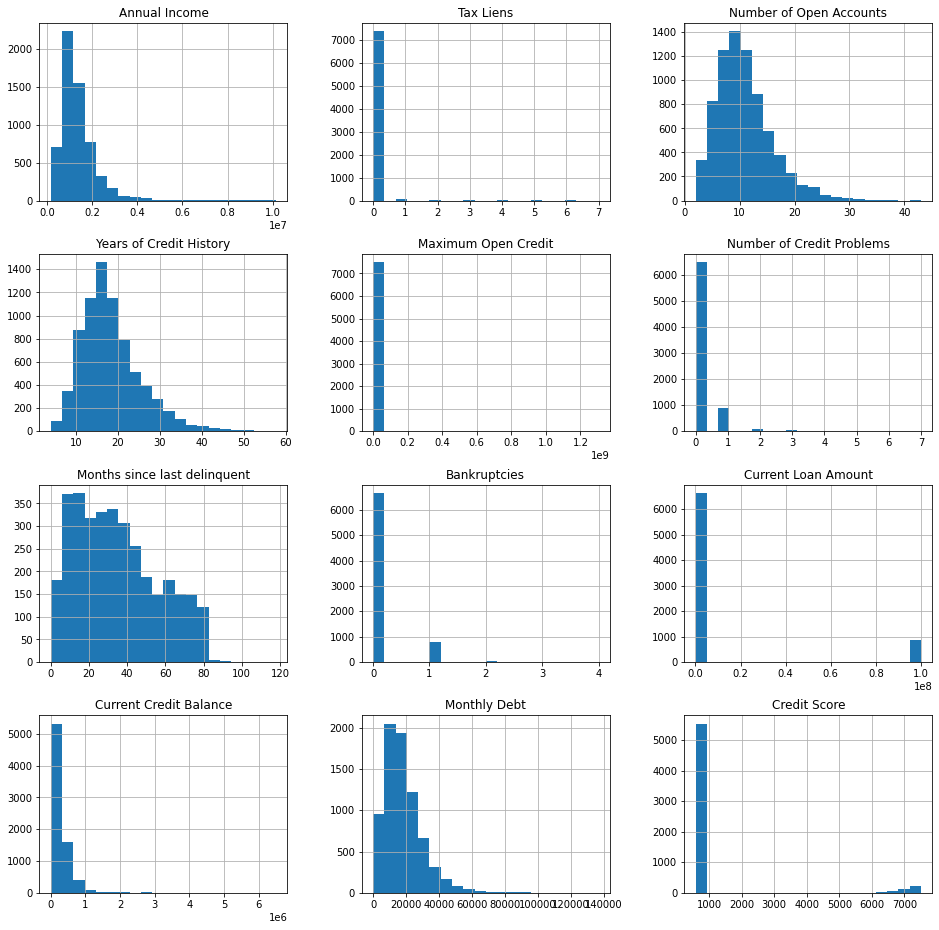

In [32]:
df[NUM_FEATURES].hist(figsize=(16, 16), bins=20)
plt.show()

**Длинный хвост (выброс)**
- Current Credit Balance
- Maximum Open Credit
- Current Loan Amount
- Months since last delinquent
- Annual Income
- Number of Open Accounts
- Years of Credit History
- Monthly Debt
- Credit History

In [33]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


наблюдаются аномалии в следующих признаках:

- Maximum Open Credit
- Current Loan Amount
- Credit Score

**Функция замены выбросов на пропуски**

In [34]:
def preprocess_outlier(data, col, threshold):
    data[f'{col}_nan'] = False
    data.loc[data[col].isna(), f'{col}_nan'] = True
    data[f'{col}_outlier'] = False
    data.loc[data[col] > threshold, f'{col}_outlier'] = True
    data.loc[data[col] > threshold, col] = np.nan
    return data

**Функция замены пропусков с помощью модели**

In [35]:
def imputer_rfr(data, target_col, depth, iterations, learning_rate, l2):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]
    
    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)
    
    model = catb.CatBoostRegressor(random_state=21,
                                   silent=True,
                                   cat_features=['Purpose', 'Term', 'Home Ownership', 'Years in current job'],
                                   depth=depth,
                                   iterations=iterations,
                                   learning_rate=learning_rate,
                                   reg_lambda=l2,
                                   early_stopping_rounds=100
                                  )
    
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f'r2 на train: {metrics.r2_score(y_train, pred_train)}')
    print(f'r2 на test: {metrics.r2_score(y_test, pred_test)}')
    
    pred = model.predict(predict_data.drop(columns=target_col))
    
    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

### Влияние признаков на целевую переменную

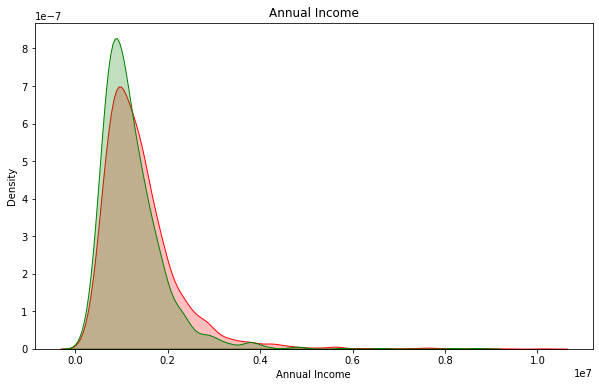

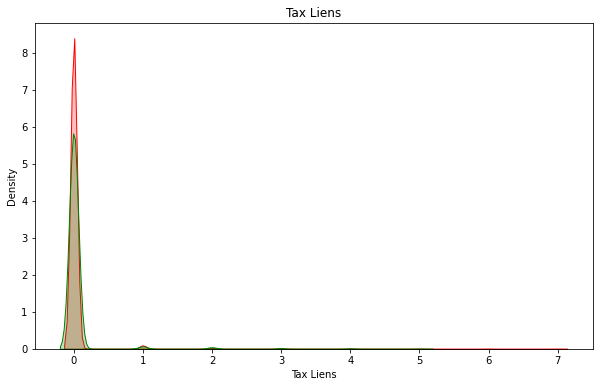

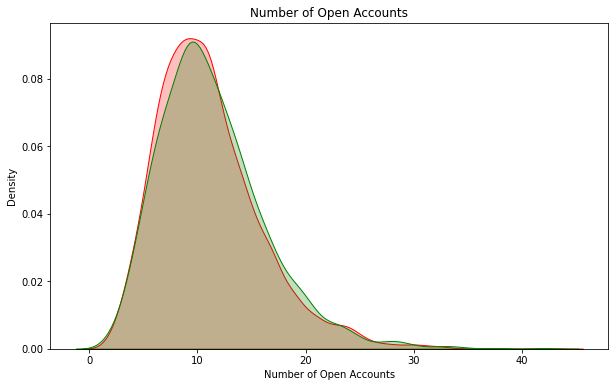

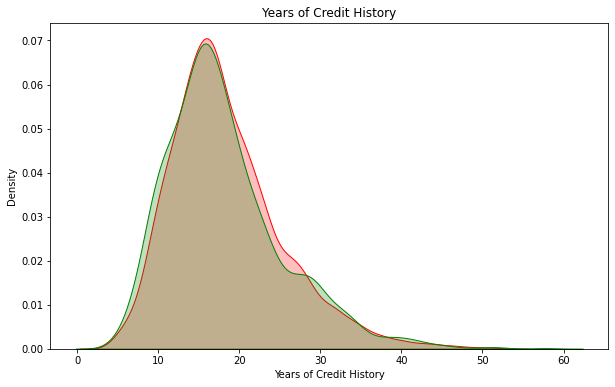

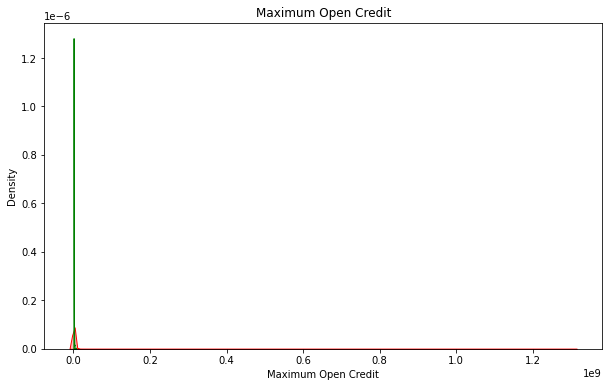

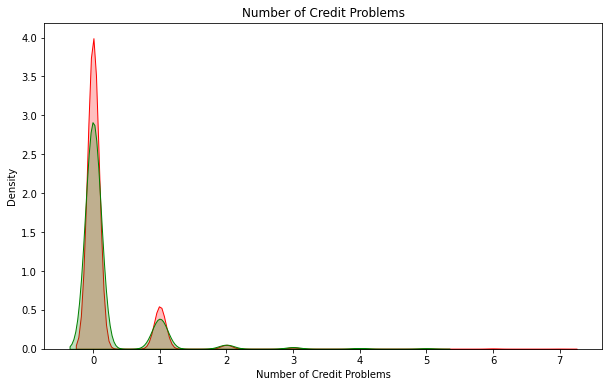

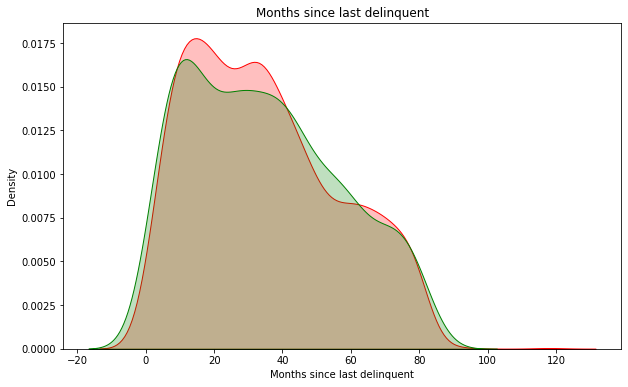

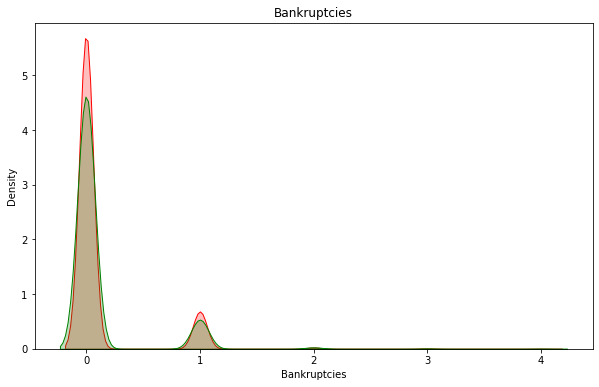

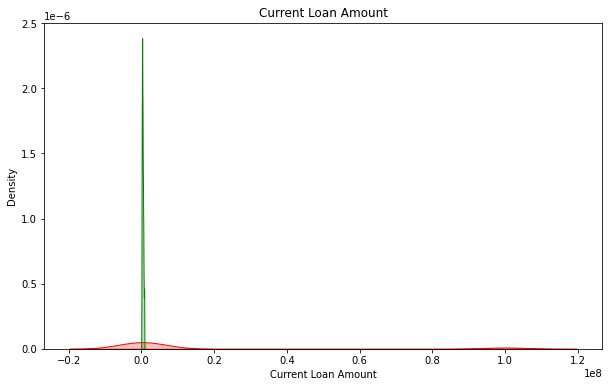

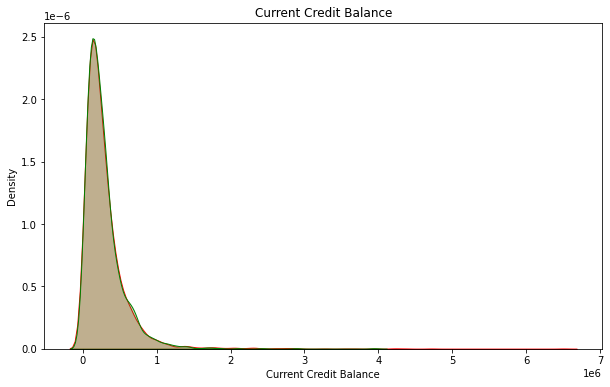

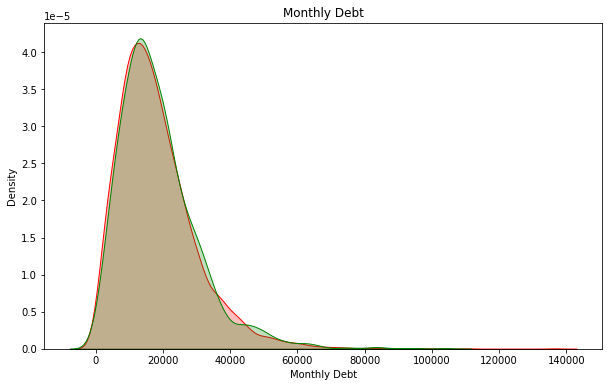

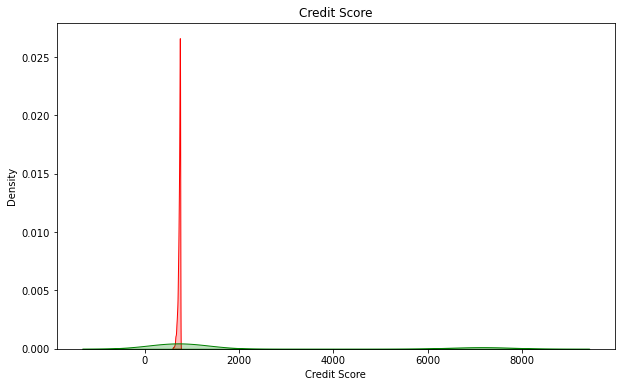

In [36]:
for feature in NUM_FEATURES:
    feature_with_target = df[[feature, TARGET_FEATURE]]
    feature = feature_with_target[feature]
    feature_0 = feature.loc[feature_with_target[TARGET_FEATURE] == 0]
    feature_1 = feature.loc[feature_with_target[TARGET_FEATURE] == 1]

    plt.figure(figsize=(10, 6))

    sns.kdeplot(feature_0, shade=True, color='r', label='0')
    sns.kdeplot(feature_1, shade=True, color='g', label='1')

    plt.title(feature.name)
    plt.show()

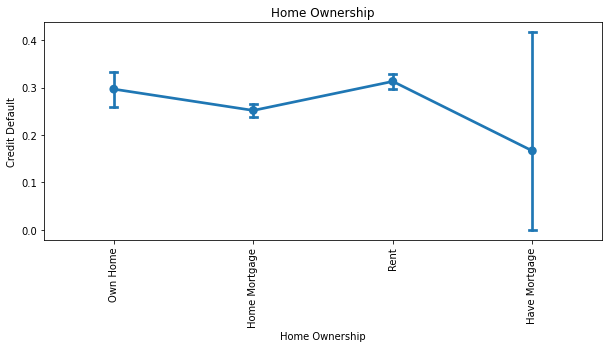

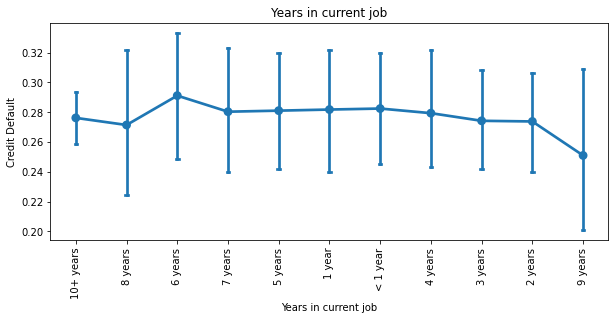

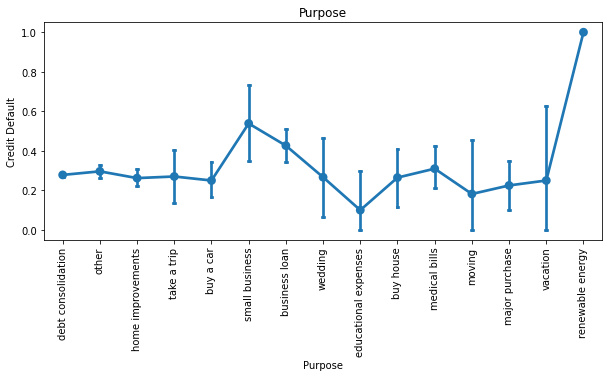

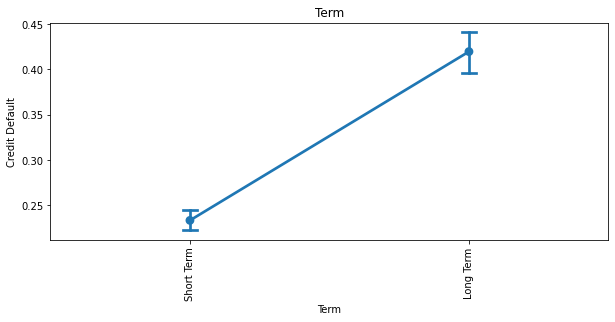

In [37]:
for feature in CAT_FEATURES:
    plt.figure(figsize=(10, 4))
    sns.pointplot(data=df, y=TARGET_FEATURE, x=feature, capsize=0.05)
    
    plt.title(feature)
    plt.xticks(rotation=90)
    plt.show()

# Предобработка данных

**Разделение данных на train и test**

In [38]:
df = train.copy()

X = df.drop(columns=TARGET_FEATURE, axis=1)
y = df[TARGET_FEATURE]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21, shuffle=True)

y_train.value_counts()[1] / y_train.value_counts()[0], y_test.value_counts()[1] / y_test.value_counts()[0]

(0.39211136890951276, 0.39275766016713093)

### Масштабирование

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaler = X_train.copy()
X_test_scaler = X_test.copy()

X_train_scaler[NUM_FEATURES] = scaler.fit_transform(X_train_scaler[NUM_FEATURES])
X_test_scaler[NUM_FEATURES] = scaler.transform(X_test_scaler[NUM_FEATURES])

X_test_scaler.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1182.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,672.000000,1498.000000,1500.000000,1500.000000,1500.000000,1182.000000
mean,-0.047932,0.052564,-0.001422,-0.003195,0.298277,0.023853,0.033142,0.020605,0.010245,0.027419,-0.030268,-0.003000
std,0.882314,1.369967,0.987012,1.017567,9.571588,1.093468,1.045475,1.037832,1.012841,1.106234,0.986199,0.992388
min,-1.399822,-0.109786,-1.855549,-2.040999,-0.198275,-0.342805,-1.607724,-0.335907,-0.370130,-0.926532,-1.537530,-0.347287
25%,-0.637153,-0.109786,-0.636442,-0.687169,-0.118588,-0.342805,-0.863248,-0.335907,-0.365224,-0.550747,-0.695318,-0.274475
50%,-0.237485,-0.109786,-0.230073,-0.202640,-0.066255,-0.342805,-0.118772,-0.335907,-0.361137,-0.247364,-0.204106,-0.261406
75%,0.293080,-0.109786,0.379481,0.509902,0.022722,-0.342805,0.858353,-0.335907,-0.354576,0.219029,0.411366,-0.254560
max,7.529675,23.843550,4.849540,5.611706,355.858236,11.924563,2.207716,11.273974,2.769530,14.251977,9.891729,3.956722


### Выявление аномалий (выбросов)

**Bankruptcies**

In [40]:
Bankruptcies_mode = X_train_scaler['Bankruptcies'].mode()[0]
X_train_scaler.loc[X_train_scaler['Bankruptcies'].isna(), 'Bankruptcies'] = Bankruptcies_mode

X_test_scaler.loc[X_test_scaler['Bankruptcies'].isna(), 'Bankruptcies'] = Bankruptcies_mode

In [41]:
X_train_scaler['Bankruptcies'].isna().sum()

0

**Years in current job**

In [42]:
years_in_current_job_mode = X_train_scaler["Years in current job"].mode()[0]

def years_in_current_job_fillna(data):
    data['Years in current job NaN'] = False
    data.loc[data["Years in current job"].isna(), "Years in current job NaN"] = True
    data.loc[data["Years in current job"].isna(), "Years in current job"] = years_in_current_job_mode
    return data

X_train_scaler = years_in_current_job_fillna(X_train_scaler)
X_test_scaler = years_in_current_job_fillna(X_test_scaler)

**Current Credit Balance**

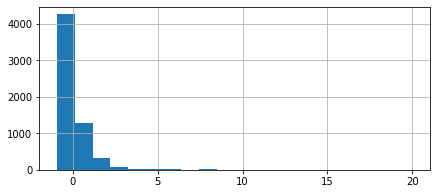

In [43]:
X_train_scaler['Current Credit Balance'].hist(figsize=(7,3), bins=20)
plt.show()

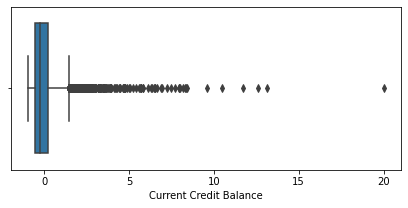

In [44]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Current Credit Balance')
plt.show()

In [45]:
preprocess_outlier(X_train_scaler, 'Current Credit Balance', 2)
preprocess_outlier(X_test_scaler, 'Current Credit Balance', 2)
X_train_scaler['Current Credit Balance'].isna().sum()

194

In [46]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
#                     'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount', 
                    'Current Credit Balance',
                    'Monthly Debt',
#                     'Credit Score'
                    ]

In [47]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Current Credit Balance', None, 300, 0.05, 100)

r2 на train: 0.6954464003481564
r2 на test: 0.6710654951873841


In [48]:
def pred_test(model, data, col_name):
    df_predict = data[data[col_name].isna()]
    pred = model.predict(df_predict[FEATURES_NOT_NAN].drop(columns=col_name))
    data.loc[data[col_name].isna(), col_name] = list(pred)
    
    return data

In [49]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Current Credit Balance')

**Monthly Debt**

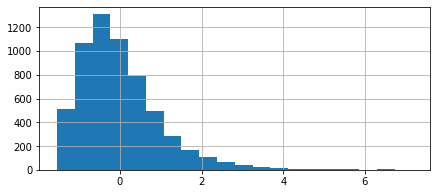

In [50]:
X_train_scaler['Monthly Debt'].hist(figsize=(7,3), bins=20)
plt.show()

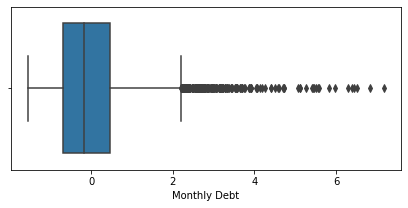

In [51]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Monthly Debt')
plt.show()

In [52]:
preprocess_outlier(X_train_scaler, 'Monthly Debt', 2.2)
preprocess_outlier(X_test_scaler, 'Monthly Debt', 2.2)
X_train_scaler['Monthly Debt'].isna().sum()

212

In [53]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
#                     'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount', 
                    'Current Credit Balance',
                    'Monthly Debt',
#                     'Credit Score'
                    ]

In [54]:
 model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Monthly Debt', 4, 100, 0.07, 100)

r2 на train: 0.40349899308751047
r2 на test: 0.3821624847432614


In [55]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Monthly Debt')

**Current Loan Amount**

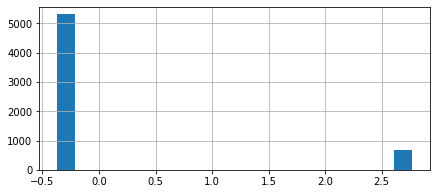

In [56]:
X_train_scaler['Current Loan Amount'].hist(figsize=(7,3), bins=20)
plt.show()

In [57]:
preprocess_outlier(X_train_scaler, 'Current Loan Amount', 2)
preprocess_outlier(X_test_scaler, 'Current Loan Amount', 2)
X_train_scaler['Current Loan Amount'].isna().sum()

692

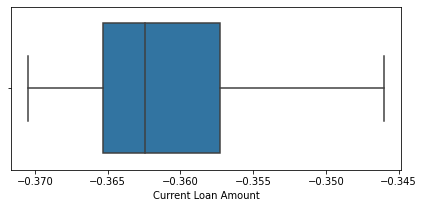

In [58]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Current Loan Amount')
plt.show()

In [59]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
#                     'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount', 
                    'Current Credit Balance',
                    'Monthly Debt',
#                     'Credit Score'
                    ]

In [60]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Current Loan Amount', None, 400, None, 10)

r2 на train: 0.4885292431163576
r2 на test: 0.46459231523388167


In [61]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Current Loan Amount')

**Annual Income**

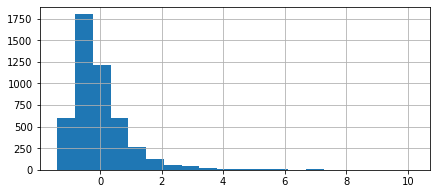

In [62]:
X_train_scaler['Annual Income'].hist(figsize=(7,3), bins=20)
plt.show()

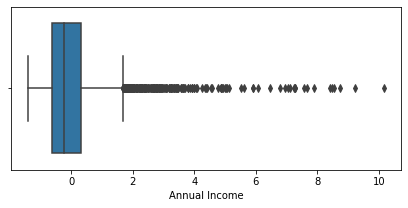

In [63]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Annual Income')
plt.show()

In [64]:
preprocess_outlier(X_train_scaler, 'Annual Income', 1.8)
preprocess_outlier(X_test_scaler, 'Annual Income', 1.8)
X_train_scaler['Annual Income'].isna().sum()

1442

In [65]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
                    'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount', 
                    'Current Credit Balance',
                    'Monthly Debt',
#                     'Credit Score'
                    ]

In [66]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Annual Income', 5, 200, 0.05, 10)

r2 на train: 0.48150991901851636
r2 на test: 0.4615275768006535


In [67]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Annual Income')

**Credit Score**

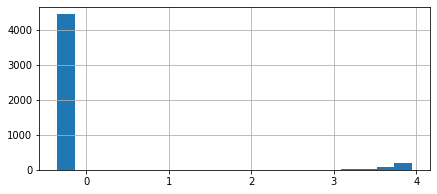

In [68]:
X_train_scaler['Credit Score'].hist(figsize=(7,3), bins=20)
plt.show()

In [69]:
preprocess_outlier(X_train_scaler, 'Credit Score', 0)
preprocess_outlier(X_test_scaler, 'Credit Score', 0)
X_train_scaler['Credit Score'].isna().sum()

1560

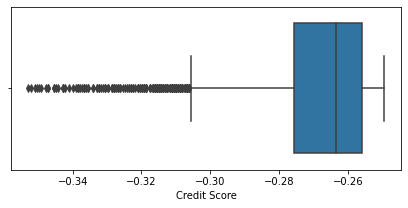

In [70]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Credit Score')
plt.show()

In [71]:
X_train_scaler.loc[X_train_scaler['Credit Score'] < -0.31, 'Credit Score'] = np.nan
X_test_scaler.loc[X_test_scaler['Credit Score'] < -0.31, 'Credit Score'] = np.nan

In [72]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
                    'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems', 
#                     'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount',
                    'Current Credit Balance',
                    'Monthly Debt',
                    'Credit Score'
                    ]

In [73]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Credit Score', None, 300, 0.05, 100)

r2 на train: 0.3610557286569469
r2 на test: 0.2805370188263947


In [74]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Credit Score')

**Months since last delinquent**

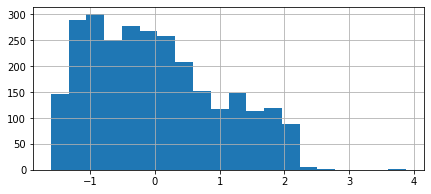

In [75]:
X_train_scaler['Months since last delinquent'].hist(figsize=(7,3), bins=20)
plt.show()

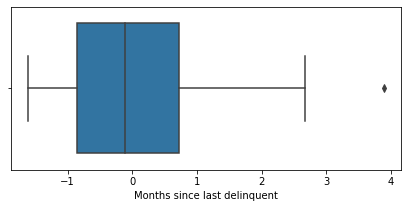

In [76]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=X_train_scaler, x='Months since last delinquent')
plt.show()

In [77]:
preprocess_outlier(X_train_scaler, 'Months since last delinquent', 2.3)
preprocess_outlier(X_test_scaler, 'Months since last delinquent', 2.3)
X_train_scaler['Months since last delinquent'].isna().sum()

3258

In [78]:
FEATURES_NOT_NAN = [
                    'Home Ownership',
                    'Purpose',
                    'Years in current job',
                    'Term',
                    'Annual Income',
                    'Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems',
                    'Months since last delinquent',
                    'Bankruptcies',
                    'Current Loan Amount',
                    'Current Credit Balance',
                    'Monthly Debt',
                    'Credit Score'
                    ]

In [79]:
model_1, X_train_scaler[FEATURES_NOT_NAN] = imputer_rfr(X_train_scaler[FEATURES_NOT_NAN], 'Months since last delinquent', None, 300, None, None)

r2 на train: 0.47441896492820623
r2 на test: -0.01207740986709882


In [80]:
X_test_scaler = pred_test(model_1, X_test_scaler, 'Months since last delinquent')

## Проверка модели

In [81]:
CAT_FEATURES = ['Home Ownership',
                'Years in current job',
                'Purpose',
                'Term']

In [82]:
X_train_scaler.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Years in current job NaN',
       'Current Credit Balance_nan', 'Current Credit Balance_outlier',
       'Monthly Debt_nan', 'Monthly Debt_outlier', 'Current Loan Amount_nan',
       'Current Loan Amount_outlier', 'Annual Income_nan',
       'Annual Income_outlier', 'Credit Score_nan', 'Credit Score_outlier',
       'Months since last delinquent_nan',
       'Months since last delinquent_outlier'],
      dtype='object')

In [83]:
NUM_FEATURES = [
#                 'Home Ownership',
                'Annual Income',
#                 'Years in current job',
                'Tax Liens', 
                'Number of Open Accounts',
                'Years of Credit History',
                'Maximum Open Credit',
                'Number of Credit Problems',
                'Months since last delinquent',
                'Bankruptcies',
#                 'Purpose',
#                 'Term',
                'Current Loan Amount',
                'Current Credit Balance',
                'Monthly Debt',
                'Credit Score',
#                 'Years in current job NaN',
#                 'Current Credit Balance_nan',
#                 'Monthly Debt_nan',
#                 'Current Loan Amount_nan',
#                 'Annual Income_nan',
#                 'Credit Score_nan',
#                 'Months since last delinquent_nan'
]

In [84]:
from scipy import stats

Annual Income
MannwhitneyuResult(statistic=4520788.0, pvalue=0.7816663188185657)


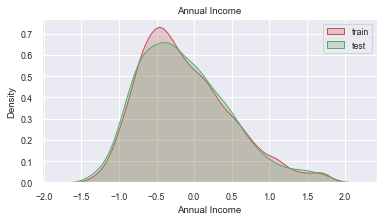

Tax Liens
MannwhitneyuResult(statistic=4494995.0, pvalue=0.7712089999757603)


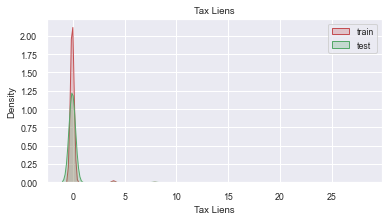

Number of Open Accounts
MannwhitneyuResult(statistic=4492502.0, pvalue=0.920176729940303)


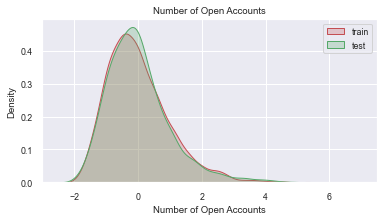

Years of Credit History
MannwhitneyuResult(statistic=4537794.0, pvalue=0.6143392983564195)


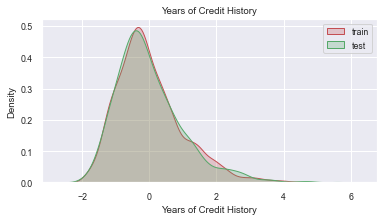

Maximum Open Credit
MannwhitneyuResult(statistic=4411678.5, pvalue=0.2389819480691211)


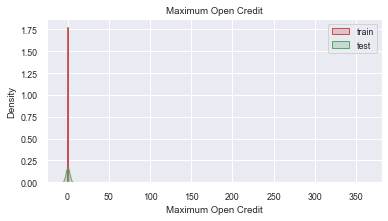

Number of Credit Problems
MannwhitneyuResult(statistic=4484604.0, pvalue=0.7310803391918215)


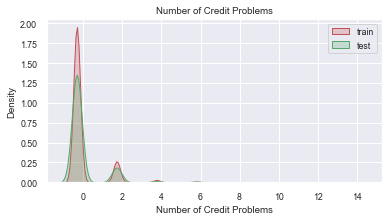

Months since last delinquent
MannwhitneyuResult(statistic=4485433.5, pvalue=0.8460174535661436)


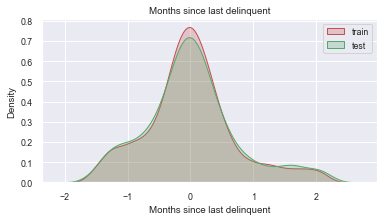

Bankruptcies
MannwhitneyuResult(statistic=4470899.5, pvalue=0.4744281164722286)


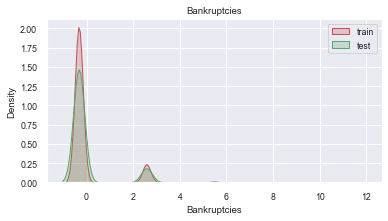

Current Loan Amount
MannwhitneyuResult(statistic=4556627.0, pvalue=0.45026717447121123)


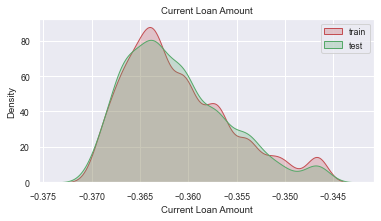

Current Credit Balance
MannwhitneyuResult(statistic=4442961.0, pvalue=0.4469780106730675)


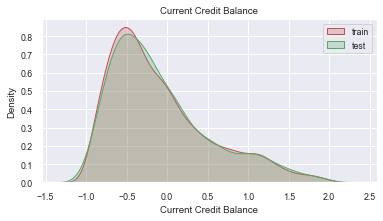

Monthly Debt
MannwhitneyuResult(statistic=4544774.0, pvalue=0.550547300316272)


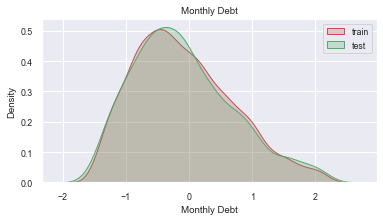

Credit Score
MannwhitneyuResult(statistic=4384123.0, pvalue=0.12234018834117323)


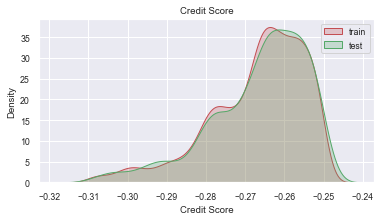

In [85]:
for col in NUM_FEATURES:
    plt.figure(figsize=(6, 3))
    sns.set(font_scale=0.8)
    sns.kdeplot(X_train_scaler[col], shade=True, label='train', color='r')
    sns.kdeplot(X_test_scaler[col], shade=True, label='test', color='g')
    print(col)
    print(stats.mannwhitneyu(X_train_scaler[col], X_test_scaler[col]))
    plt.legend()
    plt.title(col)
    plt.show()

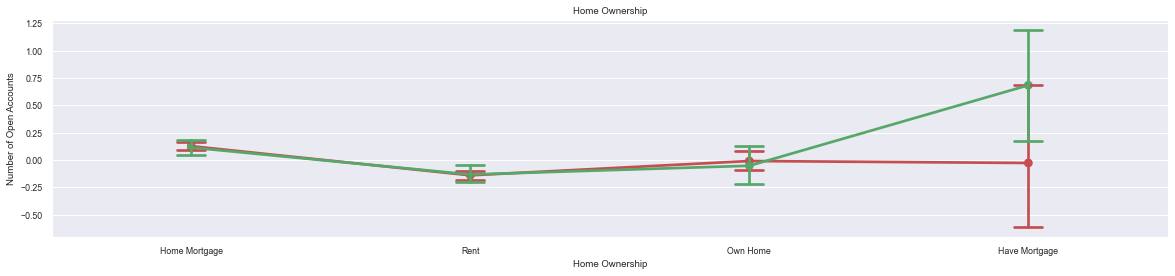

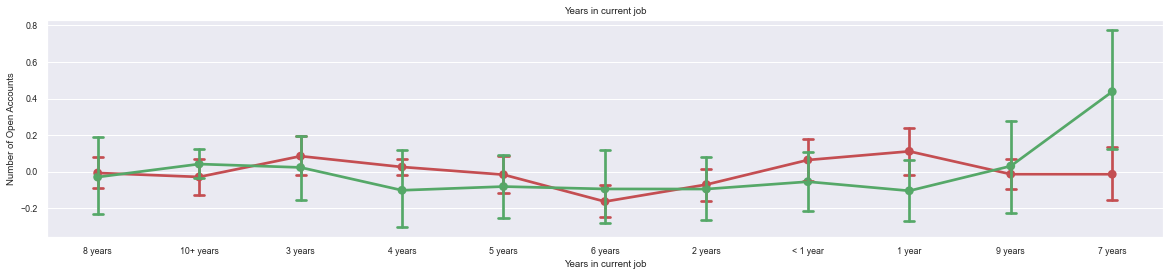

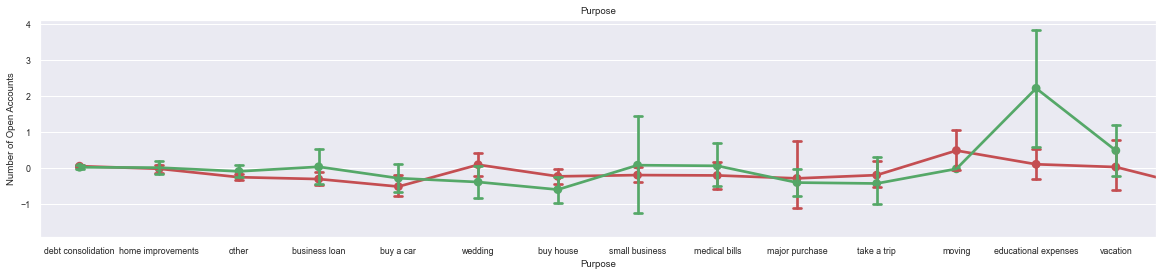

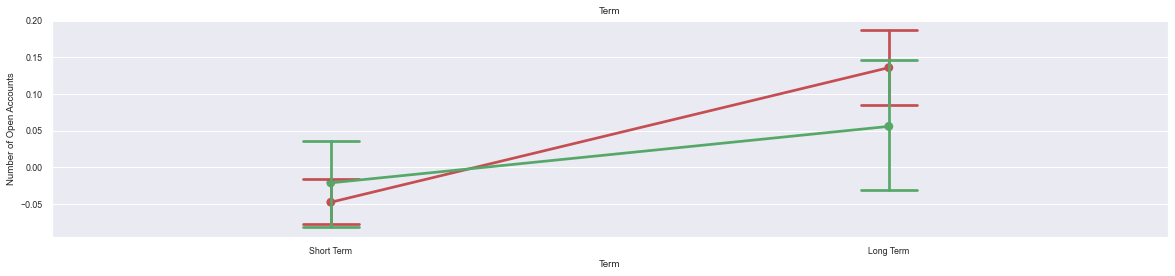

In [86]:
num_feature = 'Number of Open Accounts'
for col in CAT_FEATURES:
    plt.figure(figsize=(20, 4))
    sns.pointplot(x=col, y=num_feature, data=X_train_scaler, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=X_test_scaler, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

In [87]:
# def del_columns_purpose(data):
#     data = data.drop(index=data.loc[data['Purpose'].isin(['moving', 'renewable energy', 'educational expenses'])].index)
#     return data

# X_train_scaler = del_columns_purpose(X_train_scaler)
# X_test_scaler = del_columns_purpose(X_test_scaler)

In [88]:
def change_home_ownership(data):
    data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    return data

X_train_scaler = change_home_ownership(X_train_scaler)
X_test_scaler = change_home_ownership(X_test_scaler)

### Создание бинарных переменных

In [89]:
def home_dummies(data):
    data_home = pd.get_dummies(data["Home Ownership"]).astype(bool)
    data = pd.concat([data, data_home], axis=1)
    return data

In [90]:
X_train_scaler = home_dummies(X_train_scaler)
X_test_scaler = home_dummies(X_test_scaler)

In [91]:
def term_dummies(data):
    data_term = pd.get_dummies(data["Term"]).astype(bool)
    data = pd.concat([data, data_term], axis=1)
    return data

In [92]:
X_train_scaler = term_dummies(X_train_scaler)
X_test_scaler = term_dummies(X_test_scaler)

In [93]:
def purpose_dummies(data):
    data_purpose = pd.get_dummies(data["Purpose"]).astype(bool)
    data = pd.concat([data, data_purpose], axis=1)
    return data

In [94]:
X_train_scaler = purpose_dummies(X_train_scaler)
X_test_scaler = purpose_dummies(X_test_scaler)

### Target encoding

In [95]:
df_cat = pd.concat([X_train_scaler, y_train], axis=1).groupby('Term', as_index=False).mean()[['Term', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_term'})

df_cat

,Term,target_encode_term
0,Long Term,0.421694
1,Short Term,0.232553


In [96]:
X_train_scaler = X_train_scaler.merge(df_cat, on='Term', how='left')
X_test_scaler = X_test_scaler.merge(df_cat, on='Term', how='left')

In [97]:
df_cat = pd.concat([X_train_scaler, y_train], axis=1).groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_years_in_current_job'})
df_cat

,Home Ownership,target_encode_years_in_current_job
0,Home Mortgage,0.272492
1,Own Home,0.290865
2,Rent,0.276616


In [98]:
X_train_scaler = X_train_scaler.merge(df_cat, on='Home Ownership', how='left')
X_test_scaler = X_test_scaler.merge(df_cat, on='Home Ownership', how='left')

In [99]:
X_train_scaler

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,target_encode_term,target_encode_years_in_current_job
0,Home Mortgage,-0.595001,2 years,-0.109786,-0.636442,-0.345148,-0.011042,-0.342805,-0.304891,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.272492
1,Rent,-0.138959,1 year,15.859105,-1.245995,-1.114694,-0.164762,9.880002,0.067347,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
2,Rent,-0.707253,7 years,-0.109786,-0.433257,0.965930,-0.082901,-0.342805,0.362990,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
3,Home Mortgage,-0.746311,10+ years,-0.109786,1.395404,0.011123,-0.039313,-0.342805,1.091002,-0.335907,...,False,False,False,False,False,False,False,False,0.421694,0.272492
4,Rent,-1.054955,10+ years,-0.109786,-1.042811,-0.972186,-0.143442,-0.342805,0.105470,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,Rent,-0.829858,2 years,-0.109786,-1.042811,-1.413962,-0.170970,-0.342805,-0.242040,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
5996,Rent,-0.205119,3 years,-0.109786,1.192219,-0.900931,-0.015112,-0.342805,0.251162,-0.335907,...,False,False,False,False,False,False,False,False,0.232553,0.276616
5997,Rent,0.104931,5 years,-0.109786,-0.433257,-0.088633,-0.163987,1.701757,0.549099,2.566563,...,False,False,False,False,False,False,False,False,0.232553,0.276616
5998,Rent,0.035320,5 years,-0.109786,0.582665,-0.929433,-0.100960,-0.342805,0.125695,-0.335907,...,False,False,False,False,False,False,False,False,0.421694,0.276616


In [100]:
CAT_FEATURES = ['Home Ownership',
                'Years in current job',
                'Purpose',
                'Term']

In [101]:
X_train_scaler.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Years in current job NaN',
       'Current Credit Balance_nan', 'Current Credit Balance_outlier',
       'Monthly Debt_nan', 'Monthly Debt_outlier', 'Current Loan Amount_nan',
       'Current Loan Amount_outlier', 'Annual Income_nan',
       'Annual Income_outlier', 'Credit Score_nan', 'Credit Score_outlier',
       'Months since last delinquent_nan',
       'Months since last delinquent_outlier', 'Home Mortgage', 'Own Home',
       'Rent', 'Long Term', 'Short Term', 'business loan', 'buy a car',
       'buy house', 'debt consolidation', 'educational expenses',
       'home improvements', 'major purchase', 'medical bills', 

In [102]:
NUM_FEATURES = [
    'Home Ownership',
    'Annual Income',
#     'Years in current job',
#     'Tax Liens',
    'Number of Open Accounts',
#     'Years of Credit History',
#     'Maximum Open Credit',
    'Number of Credit Problems',
#     'Months since last delinquent',
#     'Bankruptcies',
    'Purpose',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score',
#     'Years in current job NaN',
#     'Current Credit Balance_nan',
    'Current Credit Balance_outlier',
#     'Monthly Debt_nan',
    'Monthly Debt_outlier',
#     'Current Loan Amount_nan',
    'Current Loan Amount_outlier',
    'Annual Income_nan',
    'Annual Income_outlier',
    'Credit Score_nan',
    'Credit Score_outlier',
    'Months since last delinquent_nan',
    'Months since last delinquent_outlier',
    'Home Mortgage',
#     'Own Home',
#     'Rent',
#     'Long Term',
#     'Short Term',
    'business loan',
#     'buy a car',
#     'buy house',
#     'debt consolidation',
#     'educational expenses',
#     'home improvements',
#     'major purchase',
#     'medical bills',
#     'moving',
#     'other',
#     'small business',
# #     'take a trip',
#     'vacation',
#     'wedding',
#     'target_encode_term',
#     'target_encode_years_in_current_job'
]

In [94]:
catb_model = catb.CatBoostClassifier(silent=True, random_state=2,
                                    early_stopping_rounds=100,
                                    cat_features=[
                                                'Purpose',
                                                'Term',
#                                                 'Years in current job',
                                                'Home Ownership'
                                                 ]
                                    )

catb_model.fit(X_train_scaler[NUM_FEATURES], y_train)

pred_train = catb_model.predict(X_train_scaler[NUM_FEATURES])
pred_test = catb_model.predict(X_test_scaler[NUM_FEATURES])

print('TRAIN\n', round(metrics.f1_score(y_train, pred_train), 3))
print('TEST\n', round(metrics.f1_score(y_test, pred_test), 3))

TRAIN
 0.627
TEST
 0.44


TRAIN
 0.627
TEST
 0.44

In [103]:
feature_importances = pd.DataFrame(zip(X_train_scaler[NUM_FEATURES].columns, catb_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

NameError: name 'catb_model' is not defined

### Подбор модели

In [104]:
frozen_params = {'silent':True,
                 'random_state':21,
                 'class_weights':[1, weight_min],
                 'eval_metric':'F1',
                 'early_stopping_rounds':30,
                 'cat_features':['Purpose', 'Term', 'Home Ownership']
#                  'use_best_model':True
                }

model_catb = catb.CatBoostClassifier(**frozen_params)

In [105]:
params = {'iterations': [50, 100, 200, 300, 350, 400, 450, 500, 600, 700, 1000,  1500, 2000],
         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
         'reg_lambda': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000],
         'learning_rate': [1, 0.1, 0.01, 0.001]}

In [106]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [107]:
grid_search = model_catb.grid_search(params, X_train_scaler[NUM_FEATURES], y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6916365488
bestIteration = 9

0:	loss: 0.6916365	best: 0.6916365 (0)	total: 568ms	remaining: 31m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6960010331
bestIteration = 6

1:	loss: 0.6960010	best: 0.6960010 (1)	total: 1.04s	remaining: 28m 54s

bestTest = 0.5685460223
bestIteration = 44

2:	loss: 0.5685460	best: 0.6960010 (1)	total: 1.7s	remaining: 31m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5578983196
bestIteration = 5

3:	loss: 0.5578983	best: 0.6960010 (1)	total: 2.15s	remaining: 29m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6871797573
bestIteration = 9

4:	loss: 0.6871798	best: 0.6960010 (1)	total: 2.64s	remaining: 29m 16s

bestTest = 0.6620701416
bestIteration = 49

5:	loss: 0.6620701	best: 0.6960010 (1)	total: 3.06s	remaining: 28m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6769502226
bestIteration = 8

53:	loss: 0.6769502	best: 0.6978206 (24)	total: 19.8s	remaining: 19m 58s

bestTest = 0.580996161
bestIteration = 76

54:	loss: 0.5809962	best: 0.6978206 (24)	total: 20.4s	remaining: 20m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5578983196
bestIteration = 5

55:	loss: 0.5578983	best: 0.6978206 (24)	total: 20.7s	remaining: 20m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6978205537
bestIteration = 10

56:	loss: 0.6978206	best: 0.6978206 (24)	total: 20.9s	remaining: 20m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754689493
bestIteration = 27

57:	loss: 0.6754689	best: 0.6978206 (24)	total: 21.3s	remaining: 20m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 2

58:	loss: 0.5665967	best: 0.6978206 (24)	total: 21.5s	remaining: 19m 53s
Stopped by overfitting detect

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

102:	loss: 0.5665967	best: 0.6978206 (24)	total: 36.2s	remaining: 18m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

103:	loss: 0.5665967	best: 0.6978206 (24)	total: 36.4s	remaining: 18m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754729641
bestIteration = 7

104:	loss: 0.6754730	best: 0.6978206 (24)	total: 36.6s	remaining: 18m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.682205845
bestIteration = 130

105:	loss: 0.6822058	best: 0.6978206 (24)	total: 37.7s	remaining: 19m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6278356044
bestIteration = 21

106:	loss: 0.6278356	best: 0.6978206 (24)	total: 38s	remaining: 19m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

107:	loss: 0.5665967	best: 0.6978206 (24)	to

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5705087605
bestIteration = 32

150:	loss: 0.5705088	best: 0.6978206 (24)	total: 53.6s	remaining: 18m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

151:	loss: 0.5665967	best: 0.6978206 (24)	total: 53.8s	remaining: 18m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.692039089
bestIteration = 3

152:	loss: 0.6920391	best: 0.6978206 (24)	total: 54s	remaining: 18m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6927696863
bestIteration = 8

153:	loss: 0.6927697	best: 0.6978206 (24)	total: 54.3s	remaining: 18m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

154:	loss: 0.5665967	best: 0.6978206 (24)	total: 54.5s	remaining: 18m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

155:	loss: 0.5665967	best: 0.6978206 (24)	to

198:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 8s	remaining: 17m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

199:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 8s	remaining: 17m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754729641
bestIteration = 7

200:	loss: 0.6754730	best: 0.6978206 (24)	total: 1m 8s	remaining: 17m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.682205845
bestIteration = 130

201:	loss: 0.6822058	best: 0.6978206 (24)	total: 1m 10s	remaining: 18m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6278356044
bestIteration = 21

202:	loss: 0.6278356	best: 0.6978206 (24)	total: 1m 10s	remaining: 18m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

203:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 10s	remaining: 18m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5705087605
bestIteration = 32

246:	loss: 0.5705088	best: 0.6978206 (24)	total: 1m 25s	remaining: 17m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

247:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 26s	remaining: 17m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.692039089
bestIteration = 3

248:	loss: 0.6920391	best: 0.6978206 (24)	total: 1m 26s	remaining: 17m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6927696863
bestIteration = 8

249:	loss: 0.6927697	best: 0.6978206 (24)	total: 1m 26s	remaining: 17m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

250:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 26s	remaining: 17m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

251:	loss: 0.5665967	best: 0.6978206 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

294:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 41s	remaining: 17m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

295:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 41s	remaining: 17m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754729641
bestIteration = 7

296:	loss: 0.6754730	best: 0.6978206 (24)	total: 1m 41s	remaining: 17m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.682205845
bestIteration = 130

297:	loss: 0.6822058	best: 0.6978206 (24)	total: 1m 42s	remaining: 17m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6278356044
bestIteration = 21

298:	loss: 0.6278356	best: 0.6978206 (24)	total: 1m 42s	remaining: 17m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

299:	loss: 0.5665967	best: 0.697820

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5705087605
bestIteration = 32

342:	loss: 0.5705088	best: 0.6978206 (24)	total: 1m 58s	remaining: 17m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

343:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 59s	remaining: 17m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.692039089
bestIteration = 3

344:	loss: 0.6920391	best: 0.6978206 (24)	total: 1m 59s	remaining: 17m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6927696863
bestIteration = 8

345:	loss: 0.6927697	best: 0.6978206 (24)	total: 1m 59s	remaining: 17m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

346:	loss: 0.5665967	best: 0.6978206 (24)	total: 1m 59s	remaining: 17m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

347:	loss: 0.5665967	best: 0.6978206 (

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

390:	loss: 0.5665967	best: 0.6978206 (24)	total: 2m 13s	remaining: 16m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

391:	loss: 0.5665967	best: 0.6978206 (24)	total: 2m 14s	remaining: 16m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754729641
bestIteration = 7

392:	loss: 0.6754730	best: 0.6978206 (24)	total: 2m 14s	remaining: 16m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.682205845
bestIteration = 130

393:	loss: 0.6822058	best: 0.6978206 (24)	total: 2m 15s	remaining: 16m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6278356044
bestIteration = 21

394:	loss: 0.6278356	best: 0.6978206 (24)	total: 2m 15s	remaining: 16m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

395:	loss: 0.5665967	best: 0.697820

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6874305147
bestIteration = 8

440:	loss: 0.6874305	best: 0.6978206 (24)	total: 2m 34s	remaining: 16m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6848719265
bestIteration = 2

441:	loss: 0.6848719	best: 0.6978206 (24)	total: 2m 34s	remaining: 16m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6848719265
bestIteration = 2

442:	loss: 0.6848719	best: 0.6978206 (24)	total: 2m 35s	remaining: 16m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6848719265
bestIteration = 2

443:	loss: 0.6848719	best: 0.6978206 (24)	total: 2m 35s	remaining: 16m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7233941132
bestIteration = 1

444:	loss: 0.7233941	best: 0.7233941 (444)	total: 2m 36s	remaining: 16m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6818171405
bestIteration = 7

445:	loss: 0.6818171	best: 0.7233941

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6646642145
bestIteration = 39

489:	loss: 0.6646642	best: 0.7233941 (444)	total: 3m 3s	remaining: 17m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

490:	loss: 0.5665967	best: 0.7233941 (444)	total: 3m 3s	remaining: 17m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

491:	loss: 0.5665967	best: 0.7233941 (444)	total: 3m 4s	remaining: 17m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6873289254
bestIteration = 7

492:	loss: 0.6873289	best: 0.7233941 (444)	total: 3m 4s	remaining: 17m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6774205661
bestIteration = 5

493:	loss: 0.6774206	best: 0.7233941 (444)	total: 3m 5s	remaining: 17m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

494:	loss: 0.5665967	best: 0.7233941

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6665578877
bestIteration = 57

537:	loss: 0.6665579	best: 0.7233941 (444)	total: 3m 32s	remaining: 18m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

538:	loss: 0.5665967	best: 0.7233941 (444)	total: 3m 33s	remaining: 18m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

539:	loss: 0.5665967	best: 0.7233941 (444)	total: 3m 33s	remaining: 18m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6900398646
bestIteration = 2

540:	loss: 0.6900399	best: 0.7233941 (444)	total: 3m 34s	remaining: 18m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987920478
bestIteration = 2

541:	loss: 0.6987920	best: 0.7233941 (444)	total: 3m 35s	remaining: 18m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987920478
bestIteration = 2

542:	loss: 0.6987920	best: 0.72

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6646642145
bestIteration = 39

585:	loss: 0.6646642	best: 0.7233941 (444)	total: 4m 6s	remaining: 19m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

586:	loss: 0.5665967	best: 0.7233941 (444)	total: 4m 6s	remaining: 19m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

587:	loss: 0.5665967	best: 0.7233941 (444)	total: 4m 6s	remaining: 19m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6873289254
bestIteration = 7

588:	loss: 0.6873289	best: 0.7233941 (444)	total: 4m 7s	remaining: 19m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6774205661
bestIteration = 5

589:	loss: 0.6774206	best: 0.7233941 (444)	total: 4m 7s	remaining: 19m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

590:	loss: 0.5665967	best: 0.7233941

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6665578877
bestIteration = 57

633:	loss: 0.6665579	best: 0.7233941 (444)	total: 4m 34s	remaining: 19m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

634:	loss: 0.5665967	best: 0.7233941 (444)	total: 4m 35s	remaining: 19m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

635:	loss: 0.5665967	best: 0.7233941 (444)	total: 4m 35s	remaining: 19m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6900398646
bestIteration = 2

636:	loss: 0.6900399	best: 0.7233941 (444)	total: 4m 36s	remaining: 19m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987920478
bestIteration = 2

637:	loss: 0.6987920	best: 0.7233941 (444)	total: 4m 36s	remaining: 19m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987920478
bestIteration = 2

638:	loss: 0.6987920	best: 0.72

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6646642145
bestIteration = 39

681:	loss: 0.6646642	best: 0.7233941 (444)	total: 5m 7s	remaining: 19m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

682:	loss: 0.5665967	best: 0.7233941 (444)	total: 5m 8s	remaining: 19m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

683:	loss: 0.5665967	best: 0.7233941 (444)	total: 5m 8s	remaining: 19m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6873289254
bestIteration = 7

684:	loss: 0.6873289	best: 0.7233941 (444)	total: 5m 9s	remaining: 19m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6774205661
bestIteration = 5

685:	loss: 0.6774206	best: 0.7233941 (444)	total: 5m 9s	remaining: 19m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

686:	loss: 0.5665967	best: 0.7233941

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6665578877
bestIteration = 57

729:	loss: 0.6665579	best: 0.7233941 (444)	total: 5m 35s	remaining: 19m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

730:	loss: 0.5665967	best: 0.7233941 (444)	total: 5m 36s	remaining: 19m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

731:	loss: 0.5665967	best: 0.7233941 (444)	total: 5m 36s	remaining: 19m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6900398646
bestIteration = 2

732:	loss: 0.6900399	best: 0.7233941 (444)	total: 5m 37s	remaining: 19m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987920478
bestIteration = 2

733:	loss: 0.6987920	best: 0.7233941 (444)	total: 5m 37s	remaining: 19m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987920478
bestIteration = 2

734:	loss: 0.6987920	best: 0.72

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6646642145
bestIteration = 39

777:	loss: 0.6646642	best: 0.7233941 (444)	total: 6m 6s	remaining: 20m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

778:	loss: 0.5665967	best: 0.7233941 (444)	total: 6m 6s	remaining: 20m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

779:	loss: 0.5665967	best: 0.7233941 (444)	total: 6m 7s	remaining: 20m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6873289254
bestIteration = 7

780:	loss: 0.6873289	best: 0.7233941 (444)	total: 6m 7s	remaining: 20m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6774205661
bestIteration = 5

781:	loss: 0.6774206	best: 0.7233941 (444)	total: 6m 8s	remaining: 19m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

782:	loss: 0.5665967	best: 0.7233941 (444)	total:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6665578877
bestIteration = 57

825:	loss: 0.6665579	best: 0.7233941 (444)	total: 6m 35s	remaining: 19m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

826:	loss: 0.5665967	best: 0.7233941 (444)	total: 6m 35s	remaining: 19m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

827:	loss: 0.5665967	best: 0.7233941 (444)	total: 6m 35s	remaining: 19m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6900398646
bestIteration = 2

828:	loss: 0.6900399	best: 0.7233941 (444)	total: 6m 36s	remaining: 19m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987920478
bestIteration = 2

829:	loss: 0.6987920	best: 0.7233941 (444)	total: 6m 36s	remaining: 19m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987920478
bestIteration = 2

830:	loss: 0.6987920	best: 0.72

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5690990385
bestIteration = 7

879:	loss: 0.5690990	best: 0.7233941 (444)	total: 7m 36s	remaining: 21m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6843799928
bestIteration = 9

880:	loss: 0.6843800	best: 0.7233941 (444)	total: 7m 37s	remaining: 21m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6718769104
bestIteration = 29

881:	loss: 0.6718769	best: 0.7233941 (444)	total: 7m 39s	remaining: 21m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5726267563
bestIteration = 20

882:	loss: 0.5726268	best: 0.7233941 (444)	total: 7m 40s	remaining: 21m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5690990385
bestIteration = 7

883:	loss: 0.5690990	best: 0.7233941 (444)	total: 7m 41s	remaining: 21m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6893753134
bestIteration = 2

884:	loss: 0.6893753	best: 0.72

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987017918
bestIteration = 7

928:	loss: 0.6987018	best: 0.7233941 (444)	total: 8m 41s	remaining: 22m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754682384
bestIteration = 63

929:	loss: 0.6754682	best: 0.7233941 (444)	total: 8m 43s	remaining: 22m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6508373651
bestIteration = 163

930:	loss: 0.6508374	best: 0.7233941 (444)	total: 8m 47s	remaining: 22m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

931:	loss: 0.5665967	best: 0.7233941 (444)	total: 8m 48s	remaining: 22m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6778119646
bestIteration = 4

932:	loss: 0.6778120	best: 0.7233941 (444)	total: 8m 49s	remaining: 22m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6750669873
bestIteration = 101

933:	loss: 0.6750670	best: 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6853054181
bestIteration = 3

976:	loss: 0.6853054	best: 0.7233941 (444)	total: 9m 43s	remaining: 23m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6652684224
bestIteration = 41

977:	loss: 0.6652684	best: 0.7233941 (444)	total: 9m 45s	remaining: 23m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6512330679
bestIteration = 188

978:	loss: 0.6512331	best: 0.7233941 (444)	total: 9m 51s	remaining: 23m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

979:	loss: 0.5665967	best: 0.7233941 (444)	total: 9m 52s	remaining: 23m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6859083525
bestIteration = 5

980:	loss: 0.6859084	best: 0.7233941 (444)	total: 9m 53s	remaining: 23m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6651048784
bestIteration = 39

981:	loss: 0.6651049	best: 0

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3584944893
bestIteration = 0

1023:	loss: 0.3584945	best: 0.7233941 (444)	total: 10m 45s	remaining: 24m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987017918
bestIteration = 7

1024:	loss: 0.6987018	best: 0.7233941 (444)	total: 10m 46s	remaining: 24m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754682384
bestIteration = 63

1025:	loss: 0.6754682	best: 0.7233941 (444)	total: 10m 48s	remaining: 24m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6508373651
bestIteration = 163

1026:	loss: 0.6508374	best: 0.7233941 (444)	total: 10m 52s	remaining: 24m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

1027:	loss: 0.5665967	best: 0.7233941 (444)	total: 10m 53s	remaining: 24m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6778119646
bestIteration = 4

1028:	loss: 0.67781

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

1070:	loss: 0.5665967	best: 0.7233941 (444)	total: 11m 50s	remaining: 24m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

1071:	loss: 0.5665967	best: 0.7233941 (444)	total: 11m 50s	remaining: 24m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6853054181
bestIteration = 3

1072:	loss: 0.6853054	best: 0.7233941 (444)	total: 11m 51s	remaining: 24m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6652684224
bestIteration = 41

1073:	loss: 0.6652684	best: 0.7233941 (444)	total: 11m 53s	remaining: 24m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6512330679
bestIteration = 188

1074:	loss: 0.6512331	best: 0.7233941 (444)	total: 11m 57s	remaining: 25m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

1075:	loss: 0.566596

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6863477663
bestIteration = 21

1117:	loss: 0.6863478	best: 0.7233941 (444)	total: 12m 49s	remaining: 25m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5669855286
bestIteration = 10

1118:	loss: 0.5669855	best: 0.7233941 (444)	total: 12m 51s	remaining: 25m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3584944893
bestIteration = 0

1119:	loss: 0.3584945	best: 0.7233941 (444)	total: 12m 52s	remaining: 25m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987017918
bestIteration = 7

1120:	loss: 0.6987018	best: 0.7233941 (444)	total: 12m 52s	remaining: 25m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754682384
bestIteration = 63

1121:	loss: 0.6754682	best: 0.7233941 (444)	total: 12m 54s	remaining: 25m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6508373651
bestIteration = 163

1122:	loss: 0.650

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6800324868
bestIteration = 2

1164:	loss: 0.6800325	best: 0.7233941 (444)	total: 13m 59s	remaining: 25m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6742666314
bestIteration = 46

1165:	loss: 0.6742666	best: 0.7233941 (444)	total: 14m	remaining: 25m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

1166:	loss: 0.5665967	best: 0.7233941 (444)	total: 14m 1s	remaining: 25m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

1167:	loss: 0.5665967	best: 0.7233941 (444)	total: 14m 2s	remaining: 25m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6853054181
bestIteration = 3

1168:	loss: 0.6853054	best: 0.7233941 (444)	total: 14m 3s	remaining: 25m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6652684224
bestIteration = 41

1169:	loss: 0.6652684	best:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 0

1211:	loss: 0.5665967	best: 0.7233941 (444)	total: 15m	remaining: 26m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7040191115
bestIteration = 1

1212:	loss: 0.7040191	best: 0.7233941 (444)	total: 15m 1s	remaining: 26m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6863477663
bestIteration = 21

1213:	loss: 0.6863478	best: 0.7233941 (444)	total: 15m 3s	remaining: 26m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5669855286
bestIteration = 10

1214:	loss: 0.5669855	best: 0.7233941 (444)	total: 15m 4s	remaining: 26m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3584944893
bestIteration = 0

1215:	loss: 0.3584945	best: 0.7233941 (444)	total: 15m 4s	remaining: 26m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6987017918
bestIteration = 7

1216:	loss: 0.6987018	best: 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6848127754
bestIteration = 6

1260:	loss: 0.6848128	best: 0.7233941 (444)	total: 16m 1s	remaining: 26m 15s

bestTest = 0.6586738692
bestIteration = 37

1261:	loss: 0.6586739	best: 0.7233941 (444)	total: 16m 2s	remaining: 26m 15s

bestTest = 0.6223779651
bestIteration = 49

1262:	loss: 0.6223780	best: 0.7233941 (444)	total: 16m 4s	remaining: 26m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6121090058
bestIteration = 7

1263:	loss: 0.6121090	best: 0.7233941 (444)	total: 16m 5s	remaining: 26m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6715339526
bestIteration = 6

1264:	loss: 0.6715340	best: 0.7233941 (444)	total: 16m 6s	remaining: 26m 15s

bestTest = 0.6685299079
bestIteration = 46

1265:	loss: 0.6685299	best: 0.7233941 (444)	total: 16m 7s	remaining: 26m 15s

bestTest = 0.6243158679
bestIteration = 49

1266:	loss: 0.6243159	best: 0.7233941 (444)	total: 16m 8s	remain

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6709823921
bestIteration = 91

1313:	loss: 0.6709824	best: 0.7233941 (444)	total: 17m 13s	remaining: 26m 24s

bestTest = 0.6505567289
bestIteration = 198

1314:	loss: 0.6505567	best: 0.7233941 (444)	total: 17m 21s	remaining: 26m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5790214621
bestIteration = 9

1315:	loss: 0.5790215	best: 0.7233941 (444)	total: 17m 22s	remaining: 26m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6730916046
bestIteration = 11

1316:	loss: 0.6730916	best: 0.7233941 (444)	total: 17m 24s	remaining: 26m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6639599745
bestIteration = 29

1317:	loss: 0.6639600	best: 0.7233941 (444)	total: 17m 25s	remaining: 26m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6425102935
bestIteration = 103

1318:	loss: 0.6425103	best: 0.7233941 (444)	total: 17m 30s	remaining:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6742608679
bestIteration = 25

1361:	loss: 0.6742609	best: 0.7233941 (444)	total: 19m 38s	remaining: 28m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6433578021
bestIteration = 133

1362:	loss: 0.6433578	best: 0.7233941 (444)	total: 19m 42s	remaining: 28m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6145265444
bestIteration = 24

1363:	loss: 0.6145265	best: 0.7233941 (444)	total: 19m 44s	remaining: 28m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6750816344
bestIteration = 1

1364:	loss: 0.6750816	best: 0.7233941 (444)	total: 19m 45s	remaining: 28m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6702696633
bestIteration = 54

1365:	loss: 0.6702697	best: 0.7233941 (444)	total: 19m 48s	remaining: 28m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6439974748
bestIteration = 151

1366:	loss: 0.6

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6662842702
bestIteration = 3

1408:	loss: 0.6662843	best: 0.7233941 (444)	total: 21m 52s	remaining: 29m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6709823921
bestIteration = 91

1409:	loss: 0.6709824	best: 0.7233941 (444)	total: 21m 56s	remaining: 29m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6513441783
bestIteration = 202

1410:	loss: 0.6513442	best: 0.7233941 (444)	total: 22m 5s	remaining: 30m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5790214621
bestIteration = 9

1411:	loss: 0.5790215	best: 0.7233941 (444)	total: 22m 7s	remaining: 30m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6730916046
bestIteration = 11

1412:	loss: 0.6730916	best: 0.7233941 (444)	total: 22m 8s	remaining: 30m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6639599745
bestIteration = 29

1413:	loss: 0.6639600	best

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5932879985
bestIteration = 17

1455:	loss: 0.5932880	best: 0.7233941 (444)	total: 24m 30s	remaining: 31m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6778119646
bestIteration = 4

1456:	loss: 0.6778120	best: 0.7233941 (444)	total: 24m 31s	remaining: 31m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6742608679
bestIteration = 25

1457:	loss: 0.6742609	best: 0.7233941 (444)	total: 24m 33s	remaining: 31m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6433578021
bestIteration = 133

1458:	loss: 0.6433578	best: 0.7233941 (444)	total: 24m 39s	remaining: 31m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6145265444
bestIteration = 24

1459:	loss: 0.6145265	best: 0.7233941 (444)	total: 24m 41s	remaining: 31m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6750816344
bestIteration = 1

1460:	loss: 0.675

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5550288683
bestIteration = 12

1502:	loss: 0.5550289	best: 0.7233941 (444)	total: 26m 49s	remaining: 32m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5550288683
bestIteration = 12

1503:	loss: 0.5550289	best: 0.7233941 (444)	total: 26m 51s	remaining: 32m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6662842702
bestIteration = 3

1504:	loss: 0.6662843	best: 0.7233941 (444)	total: 26m 52s	remaining: 32m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6709823921
bestIteration = 91

1505:	loss: 0.6709824	best: 0.7233941 (444)	total: 26m 57s	remaining: 32m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6513441783
bestIteration = 202

1506:	loss: 0.6513442	best: 0.7233941 (444)	total: 27m 6s	remaining: 32m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5790214621
bestIteration = 9

1507:	loss: 0.5790

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6758706905
bestIteration = 95

1549:	loss: 0.6758707	best: 0.7233941 (444)	total: 29m 13s	remaining: 33m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6466430066
bestIteration = 197

1550:	loss: 0.6466430	best: 0.7233941 (444)	total: 29m 21s	remaining: 33m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5932879985
bestIteration = 17

1551:	loss: 0.5932880	best: 0.7233941 (444)	total: 29m 22s	remaining: 33m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6778119646
bestIteration = 4

1552:	loss: 0.6778120	best: 0.7233941 (444)	total: 29m 23s	remaining: 33m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6742608679
bestIteration = 25

1553:	loss: 0.6742609	best: 0.7233941 (444)	total: 29m 25s	remaining: 33m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6433578021
bestIteration = 133

1554:	loss: 0.6

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6937696722
bestIteration = 28

1596:	loss: 0.6937697	best: 0.7233941 (444)	total: 31m 43s	remaining: 34m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6477604086
bestIteration = 4

1597:	loss: 0.6477604	best: 0.7233941 (444)	total: 31m 45s	remaining: 34m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5550288683
bestIteration = 12

1598:	loss: 0.5550289	best: 0.7233941 (444)	total: 31m 46s	remaining: 34m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5550288683
bestIteration = 12

1599:	loss: 0.5550289	best: 0.7233941 (444)	total: 31m 48s	remaining: 34m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6662842702
bestIteration = 3

1600:	loss: 0.6662843	best: 0.7233941 (444)	total: 31m 49s	remaining: 34m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6709823921
bestIteration = 91

1601:	loss: 0.6709

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6089839132
bestIteration = 19

1643:	loss: 0.6089839	best: 0.7233941 (444)	total: 34m 6s	remaining: 34m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6878233162
bestIteration = 10

1644:	loss: 0.6878233	best: 0.7233941 (444)	total: 34m 8s	remaining: 34m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6758706905
bestIteration = 95

1645:	loss: 0.6758707	best: 0.7233941 (444)	total: 34m 12s	remaining: 34m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6466430066
bestIteration = 197

1646:	loss: 0.6466430	best: 0.7233941 (444)	total: 34m 21s	remaining: 35m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5932879985
bestIteration = 17

1647:	loss: 0.5932880	best: 0.7233941 (444)	total: 34m 23s	remaining: 35m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6778119646
bestIteration = 4

1648:	loss: 0.677812

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6327168379
bestIteration = 12

1691:	loss: 0.6327168	best: 0.7233941 (444)	total: 35m 35s	remaining: 34m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6901895845
bestIteration = 9

1692:	loss: 0.6901896	best: 0.7233941 (444)	total: 35m 37s	remaining: 34m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6618209991
bestIteration = 7

1693:	loss: 0.6618210	best: 0.7233941 (444)	total: 35m 38s	remaining: 34m 22s

bestTest = 0.6098587743
bestIteration = 45

1694:	loss: 0.6098588	best: 0.7233941 (444)	total: 35m 39s	remaining: 34m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5947575561
bestIteration = 0

1695:	loss: 0.5947576	best: 0.7233941 (444)	total: 35m 40s	remaining: 34m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6662441008
bestIteration = 0

1696:	loss: 0.6662441	best: 0.7233941 (444)	total: 35m 41s	remaining: 34m 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6731343679
bestIteration = 3

1740:	loss: 0.6731344	best: 0.7233941 (444)	total: 36m 48s	remaining: 33m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6875555859
bestIteration = 49

1741:	loss: 0.6875556	best: 0.7233941 (444)	total: 36m 51s	remaining: 33m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.651917307
bestIteration = 91

1742:	loss: 0.6519173	best: 0.7233941 (444)	total: 36m 54s	remaining: 33m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5681550942
bestIteration = 3

1743:	loss: 0.5681551	best: 0.7233941 (444)	total: 36m 56s	remaining: 33m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754678781
bestIteration = 6

1744:	loss: 0.6754679	best: 0.7233941 (444)	total: 36m 57s	remaining: 33m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6774708511
bestIteration = 34

1745:	loss: 0.677470

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

1787:	loss: 0.5665967	best: 0.7233941 (444)	total: 38m 39s	remaining: 33m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6832047353
bestIteration = 42

1788:	loss: 0.6832047	best: 0.7233941 (444)	total: 38m 41s	remaining: 33m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6762678611
bestIteration = 87

1789:	loss: 0.6762679	best: 0.7233941 (444)	total: 38m 45s	remaining: 33m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6246807915
bestIteration = 74

1790:	loss: 0.6246808	best: 0.7233941 (444)	total: 38m 48s	remaining: 33m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.433733338
bestIteration = 4

1791:	loss: 0.4337333	best: 0.7233941 (444)	total: 38m 49s	remaining: 33m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6661585517
bestIteration = 7

1792:	loss: 0.666158

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6590734495
bestIteration = 221

1834:	loss: 0.6590734	best: 0.7233941 (444)	total: 40m 35s	remaining: 33m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5681550942
bestIteration = 3

1835:	loss: 0.5681551	best: 0.7233941 (444)	total: 40m 36s	remaining: 33m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6731343679
bestIteration = 3

1836:	loss: 0.6731344	best: 0.7233941 (444)	total: 40m 37s	remaining: 32m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6875555859
bestIteration = 49

1837:	loss: 0.6875556	best: 0.7233941 (444)	total: 40m 40s	remaining: 32m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.651917307
bestIteration = 91

1838:	loss: 0.6519173	best: 0.7233941 (444)	total: 40m 43s	remaining: 32m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5681550942
bestIteration = 3

1839:	loss: 0.5681551	be

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6826693942
bestIteration = 118

1881:	loss: 0.6826694	best: 0.7233941 (444)	total: 42m 22s	remaining: 32m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

1882:	loss: 0.5665967	best: 0.7233941 (444)	total: 42m 23s	remaining: 32m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

1883:	loss: 0.5665967	best: 0.7233941 (444)	total: 42m 23s	remaining: 32m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6832047353
bestIteration = 42

1884:	loss: 0.6832047	best: 0.7233941 (444)	total: 42m 26s	remaining: 32m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6762678611
bestIteration = 87

1885:	loss: 0.6762679	best: 0.7233941 (444)	total: 42m 29s	remaining: 32m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6246807915
bestIteration = 74

1886:	loss: 0.624

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6719570014
bestIteration = 3

1928:	loss: 0.6719570	best: 0.7233941 (444)	total: 44m 9s	remaining: 32m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6734206056
bestIteration = 63

1929:	loss: 0.6734206	best: 0.7233941 (444)	total: 44m 11s	remaining: 32m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6590734495
bestIteration = 221

1930:	loss: 0.6590734	best: 0.7233941 (444)	total: 44m 20s	remaining: 32m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5681550942
bestIteration = 3

1931:	loss: 0.5681551	best: 0.7233941 (444)	total: 44m 21s	remaining: 32m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6731343679
bestIteration = 3

1932:	loss: 0.6731344	best: 0.7233941 (444)	total: 44m 21s	remaining: 32m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6875555859
bestIteration = 49

1933:	loss: 0.6875556	best:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5681550942
bestIteration = 3

1975:	loss: 0.5681551	best: 0.7233941 (444)	total: 46m 1s	remaining: 31m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7059349044
bestIteration = 2

1976:	loss: 0.7059349	best: 0.7233941 (444)	total: 46m 1s	remaining: 31m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6826693942
bestIteration = 118

1977:	loss: 0.6826694	best: 0.7233941 (444)	total: 46m 6s	remaining: 31m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

1978:	loss: 0.5665967	best: 0.7233941 (444)	total: 46m 7s	remaining: 31m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

1979:	loss: 0.5665967	best: 0.7233941 (444)	total: 46m 8s	remaining: 31m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6832047353
bestIteration = 42

1980:	loss: 0.6832047	be

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6523162252
bestIteration = 179

2022:	loss: 0.6523162	best: 0.7233941 (444)	total: 47m 49s	remaining: 30m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5690990385
bestIteration = 23

2023:	loss: 0.5690990	best: 0.7233941 (444)	total: 47m 51s	remaining: 30m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6719570014
bestIteration = 3

2024:	loss: 0.6719570	best: 0.7233941 (444)	total: 47m 52s	remaining: 30m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6734206056
bestIteration = 63

2025:	loss: 0.6734206	best: 0.7233941 (444)	total: 47m 55s	remaining: 30m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6590734495
bestIteration = 221

2026:	loss: 0.6590734	best: 0.7233941 (444)	total: 48m 3s	remaining: 30m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5681550942
bestIteration = 3

2027:	loss: 0.568

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6702459643
bestIteration = 65

2069:	loss: 0.6702460	best: 0.7233941 (444)	total: 49m 40s	remaining: 30m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6269207808
bestIteration = 69

2070:	loss: 0.6269208	best: 0.7233941 (444)	total: 49m 44s	remaining: 30m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5681550942
bestIteration = 3

2071:	loss: 0.5681551	best: 0.7233941 (444)	total: 49m 44s	remaining: 30m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7059349044
bestIteration = 2

2072:	loss: 0.7059349	best: 0.7233941 (444)	total: 49m 46s	remaining: 30m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6826693942
bestIteration = 118

2073:	loss: 0.6826694	best: 0.7233941 (444)	total: 49m 50s	remaining: 30m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5665967428
bestIteration = 1

2074:	loss: 0.5665967

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6471707318
bestIteration = 12

2117:	loss: 0.6471707	best: 0.7233941 (444)	total: 50m 47s	remaining: 29m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6436982415
bestIteration = 0

2118:	loss: 0.6436982	best: 0.7233941 (444)	total: 50m 48s	remaining: 28m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6436982415
bestIteration = 0

2119:	loss: 0.6436982	best: 0.7233941 (444)	total: 50m 49s	remaining: 28m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6436982415
bestIteration = 0

2120:	loss: 0.6436982	best: 0.7233941 (444)	total: 50m 49s	remaining: 28m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6604140004
bestIteration = 14

2121:	loss: 0.6604140	best: 0.7233941 (444)	total: 50m 51s	remaining: 28m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6436982415
bestIteration = 0

2122:	loss: 0.6436982	be

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6750712651
bestIteration = 3

2164:	loss: 0.6750713	best: 0.7233941 (444)	total: 51m 47s	remaining: 27m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6806998484
bestIteration = 42

2165:	loss: 0.6806998	best: 0.7233941 (444)	total: 51m 49s	remaining: 27m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6127310653
bestIteration = 2

2166:	loss: 0.6127311	best: 0.7233941 (444)	total: 51m 50s	remaining: 27m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6127310653
bestIteration = 2

2167:	loss: 0.6127311	best: 0.7233941 (444)	total: 51m 52s	remaining: 27m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6640498887
bestIteration = 1

2168:	loss: 0.6640499	best: 0.7233941 (444)	total: 51m 53s	remaining: 27m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6652684224
bestIteration = 44

2169:	loss: 0.665268

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6555855259
bestIteration = 2

2211:	loss: 0.6555855	best: 0.7233941 (444)	total: 53m 17s	remaining: 26m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6690814995
bestIteration = 8

2212:	loss: 0.6690815	best: 0.7233941 (444)	total: 53m 18s	remaining: 26m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6665170098
bestIteration = 23

2213:	loss: 0.6665170	best: 0.7233941 (444)	total: 53m 20s	remaining: 26m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6325240775
bestIteration = 2

2214:	loss: 0.6325241	best: 0.7233941 (444)	total: 53m 21s	remaining: 26m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6555855259
bestIteration = 2

2215:	loss: 0.6555855	best: 0.7233941 (444)	total: 53m 22s	remaining: 26m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6735047195
bestIteration = 2

2216:	loss: 0.6735047

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6131291996
bestIteration = 2

2258:	loss: 0.6131292	best: 0.7233941 (444)	total: 54m 35s	remaining: 25m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6131291996
bestIteration = 2

2259:	loss: 0.6131292	best: 0.7233941 (444)	total: 54m 36s	remaining: 25m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6750712651
bestIteration = 3

2260:	loss: 0.6750713	best: 0.7233941 (444)	total: 54m 37s	remaining: 25m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6806998484
bestIteration = 42

2261:	loss: 0.6806998	best: 0.7233941 (444)	total: 54m 40s	remaining: 25m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6127310653
bestIteration = 2

2262:	loss: 0.6127311	best: 0.7233941 (444)	total: 54m 41s	remaining: 25m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6127310653
bestIteration = 2

2263:	loss: 0.6127311

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6678287806
bestIteration = 28

2305:	loss: 0.6678288	best: 0.7233941 (444)	total: 56m 5s	remaining: 24m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6333188553
bestIteration = 3

2306:	loss: 0.6333189	best: 0.7233941 (444)	total: 56m 7s	remaining: 24m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6555855259
bestIteration = 2

2307:	loss: 0.6555855	best: 0.7233941 (444)	total: 56m 8s	remaining: 24m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6690814995
bestIteration = 8

2308:	loss: 0.6690815	best: 0.7233941 (444)	total: 56m 9s	remaining: 24m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6665170098
bestIteration = 23

2309:	loss: 0.6665170	best: 0.7233941 (444)	total: 56m 11s	remaining: 24m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6325240775
bestIteration = 2

2310:	loss: 0.6325241	be

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6710439633
bestIteration = 9

2352:	loss: 0.6710440	best: 0.7233941 (444)	total: 57m 21s	remaining: 23m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6538161388
bestIteration = 22

2353:	loss: 0.6538161	best: 0.7233941 (444)	total: 57m 23s	remaining: 23m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6131291996
bestIteration = 2

2354:	loss: 0.6131292	best: 0.7233941 (444)	total: 57m 24s	remaining: 23m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6131291996
bestIteration = 2

2355:	loss: 0.6131292	best: 0.7233941 (444)	total: 57m 25s	remaining: 23m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6750712651
bestIteration = 3

2356:	loss: 0.6750713	best: 0.7233941 (444)	total: 57m 26s	remaining: 23m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6806998484
bestIteration = 42

2357:	loss: 0.680699

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3884055891
bestIteration = 29

2399:	loss: 0.3884056	best: 0.7233941 (444)	total: 58m 50s	remaining: 22m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6481886211
bestIteration = 4

2400:	loss: 0.6481886	best: 0.7233941 (444)	total: 58m 51s	remaining: 22m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6678287806
bestIteration = 28

2401:	loss: 0.6678288	best: 0.7233941 (444)	total: 58m 53s	remaining: 22m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6333188553
bestIteration = 3

2402:	loss: 0.6333189	best: 0.7233941 (444)	total: 58m 55s	remaining: 22m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6555855259
bestIteration = 2

2403:	loss: 0.6555855	best: 0.7233941 (444)	total: 58m 56s	remaining: 22m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6690814995
bestIteration = 8

2404:	loss: 0.669081

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6474387853
bestIteration = 2

2446:	loss: 0.6474388	best: 0.7233941 (444)	total: 1h 2s	remaining: 21m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6555855259
bestIteration = 2

2447:	loss: 0.6555855	best: 0.7233941 (444)	total: 1h 3s	remaining: 21m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6710439633
bestIteration = 9

2448:	loss: 0.6710440	best: 0.7233941 (444)	total: 1h 5s	remaining: 21m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6538161388
bestIteration = 22

2449:	loss: 0.6538161	best: 0.7233941 (444)	total: 1h 6s	remaining: 21m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6131291996
bestIteration = 2

2450:	loss: 0.6131292	best: 0.7233941 (444)	total: 1h 7s	remaining: 21m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6131291996
bestIteration = 2

2451:	loss: 0.6131292	best: 0.7

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6825751382
bestIteration = 240

2493:	loss: 0.6825751	best: 0.7233941 (444)	total: 1h 1m 20s	remaining: 20m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6393551245
bestIteration = 110

2494:	loss: 0.6393551	best: 0.7233941 (444)	total: 1h 1m 24s	remaining: 20m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3884055891
bestIteration = 29

2495:	loss: 0.3884056	best: 0.7233941 (444)	total: 1h 1m 26s	remaining: 20m 28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6659760658
bestIteration = 1

2496:	loss: 0.6659761	best: 0.7233941 (444)	total: 1h 1m 27s	remaining: 20m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6511143194
bestIteration = 0

2497:	loss: 0.6511143	best: 0.7233941 (444)	total: 1h 1m 29s	remaining: 20m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6520259186
bestIteration = 1

2498:	l

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6701735731
bestIteration = 16

2541:	loss: 0.6701736	best: 0.7233941 (444)	total: 1h 2m 24s	remaining: 19m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6630960798
bestIteration = 19

2542:	loss: 0.6630961	best: 0.7233941 (444)	total: 1h 2m 26s	remaining: 19m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6520259186
bestIteration = 1

2543:	loss: 0.6520259	best: 0.7233941 (444)	total: 1h 2m 27s	remaining: 19m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.654965427
bestIteration = 1

2544:	loss: 0.6549654	best: 0.7233941 (444)	total: 1h 2m 28s	remaining: 19m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6770762143
bestIteration = 12

2545:	loss: 0.6770762	best: 0.7233941 (444)	total: 1h 2m 29s	remaining: 19m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6520259186
bestIteration = 1

2546:	loss

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.692353189
bestIteration = 8

2588:	loss: 0.6923532	best: 0.7233941 (444)	total: 1h 3m 53s	remaining: 18m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6770558908
bestIteration = 122

2589:	loss: 0.6770559	best: 0.7233941 (444)	total: 1h 3m 58s	remaining: 18m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3836808645
bestIteration = 8

2590:	loss: 0.3836809	best: 0.7233941 (444)	total: 1h 3m 59s	remaining: 18m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3836808645
bestIteration = 8

2591:	loss: 0.3836809	best: 0.7233941 (444)	total: 1h 4m	remaining: 18m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573299666
bestIteration = 2

2592:	loss: 0.6573300	best: 0.7233941 (444)	total: 1h 4m 2s	remaining: 18m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.661075352
bestIteration = 8

2593:	loss: 0.6610

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5822708459
bestIteration = 2

2635:	loss: 0.5822708	best: 0.7233941 (444)	total: 1h 5m 42s	remaining: 17m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6696096436
bestIteration = 4

2636:	loss: 0.6696096	best: 0.7233941 (444)	total: 1h 5m 44s	remaining: 17m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6686246362
bestIteration = 12

2637:	loss: 0.6686246	best: 0.7233941 (444)	total: 1h 5m 45s	remaining: 17m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.646638001
bestIteration = 155

2638:	loss: 0.6466380	best: 0.7233941 (444)	total: 1h 5m 51s	remaining: 17m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5822708459
bestIteration = 2

2639:	loss: 0.5822708	best: 0.7233941 (444)	total: 1h 5m 53s	remaining: 17m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6690814995
bestIteration = 6

2640:	loss

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5777339926
bestIteration = 1

2682:	loss: 0.5777340	best: 0.7233941 (444)	total: 1h 7m 21s	remaining: 16m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5777339926
bestIteration = 1

2683:	loss: 0.5777340	best: 0.7233941 (444)	total: 1h 7m 22s	remaining: 16m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.692353189
bestIteration = 8

2684:	loss: 0.6923532	best: 0.7233941 (444)	total: 1h 7m 24s	remaining: 16m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6770558908
bestIteration = 122

2685:	loss: 0.6770559	best: 0.7233941 (444)	total: 1h 7m 29s	remaining: 16m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3836808645
bestIteration = 8

2686:	loss: 0.3836809	best: 0.7233941 (444)	total: 1h 7m 30s	remaining: 16m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3836808645
bestIteration = 8

2687:	loss: 0.

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6587659692
bestIteration = 12

2729:	loss: 0.6587660	best: 0.7233941 (444)	total: 1h 9m 5s	remaining: 15m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6454176465
bestIteration = 108

2730:	loss: 0.6454176	best: 0.7233941 (444)	total: 1h 9m 10s	remaining: 15m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5822708459
bestIteration = 2

2731:	loss: 0.5822708	best: 0.7233941 (444)	total: 1h 9m 11s	remaining: 15m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6696096436
bestIteration = 4

2732:	loss: 0.6696096	best: 0.7233941 (444)	total: 1h 9m 13s	remaining: 15m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6686246362
bestIteration = 12

2733:	loss: 0.6686246	best: 0.7233941 (444)	total: 1h 9m 14s	remaining: 15m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.646638001
bestIteration = 155

2734:	loss: 0

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6355038566
bestIteration = 0

2775:	loss: 0.6355039	best: 0.7233941 (444)	total: 1h 10m 44s	remaining: 14m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6566316436
bestIteration = 11

2776:	loss: 0.6566316	best: 0.7233941 (444)	total: 1h 10m 46s	remaining: 14m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6762646609
bestIteration = 95

2777:	loss: 0.6762647	best: 0.7233941 (444)	total: 1h 10m 50s	remaining: 14m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5777339926
bestIteration = 1

2778:	loss: 0.5777340	best: 0.7233941 (444)	total: 1h 10m 51s	remaining: 13m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5777339926
bestIteration = 1

2779:	loss: 0.5777340	best: 0.7233941 (444)	total: 1h 10m 53s	remaining: 13m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.692353189
bestIteration = 8

2780:	los

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6637192309
bestIteration = 32

2821:	loss: 0.6637192	best: 0.7233941 (444)	total: 1h 12m 20s	remaining: 12m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6522854529
bestIteration = 196

2822:	loss: 0.6522855	best: 0.7233941 (444)	total: 1h 12m 28s	remaining: 12m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5822708459
bestIteration = 2

2823:	loss: 0.5822708	best: 0.7233941 (444)	total: 1h 12m 29s	remaining: 12m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6694770858
bestIteration = 5

2824:	loss: 0.6694771	best: 0.7233941 (444)	total: 1h 12m 30s	remaining: 12m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6587659692
bestIteration = 12

2825:	loss: 0.6587660	best: 0.7233941 (444)	total: 1h 12m 32s	remaining: 12m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6454176465
bestIteration = 108

2

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6355038566
bestIteration = 0

2867:	loss: 0.6355039	best: 0.7233941 (444)	total: 1h 14m 21s	remaining: 11m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.676274348
bestIteration = 9

2868:	loss: 0.6762743	best: 0.7233941 (444)	total: 1h 14m 23s	remaining: 11m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6544160966
bestIteration = 20

2869:	loss: 0.6544161	best: 0.7233941 (444)	total: 1h 14m 25s	remaining: 11m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6355038566
bestIteration = 0

2870:	loss: 0.6355039	best: 0.7233941 (444)	total: 1h 14m 27s	remaining: 11m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6355038566
bestIteration = 0

2871:	loss: 0.6355039	best: 0.7233941 (444)	total: 1h 14m 28s	remaining: 11m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6566316436
bestIteration = 11

2872:	

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2913:	loss: 0.6563284	best: 0.7233941 (444)	total: 1h 16m 17s	remaining: 10m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2914:	loss: 0.6563284	best: 0.7233941 (444)	total: 1h 16m 19s	remaining: 10m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2915:	loss: 0.6563284	best: 0.7233941 (444)	total: 1h 16m 20s	remaining: 10m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2916:	loss: 0.6563284	best: 0.7233941 (444)	total: 1h 16m 22s	remaining: 10m 45s

bestTest = 0.6680923734
bestIteration = 24

2917:	loss: 0.6680924	best: 0.7233941 (444)	total: 1h 16m 24s	remaining: 10m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2918:	loss: 0.6563284	best: 0.7233941 (444)	total: 1h 16m 26

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6596195245
bestIteration = 22

2961:	loss: 0.6596195	best: 0.7233941 (444)	total: 1h 17m 47s	remaining: 9m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2962:	loss: 0.6563284	best: 0.7233941 (444)	total: 1h 17m 49s	remaining: 9m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2963:	loss: 0.6563284	best: 0.7233941 (444)	total: 1h 17m 50s	remaining: 9m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2964:	loss: 0.6563284	best: 0.7233941 (444)	total: 1h 17m 52s	remaining: 9m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6578761603
bestIteration = 20

2965:	loss: 0.6578762	best: 0.7233941 (444)	total: 1h 17m 54s	remaining: 9m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6563283656
bestIteration = 0

2966:	loss

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6583480084
bestIteration = 3

3008:	loss: 0.6583480	best: 0.7233941 (444)	total: 1h 19m 31s	remaining: 8m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6458391952
bestIteration = 24

3009:	loss: 0.6458392	best: 0.7233941 (444)	total: 1h 19m 34s	remaining: 8m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3010:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 19m 36s	remaining: 8m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3011:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 19m 38s	remaining: 8m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6564981675
bestIteration = 1

3012:	loss: 0.6564982	best: 0.7233941 (444)	total: 1h 19m 40s	remaining: 8m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.649888154
bestIteration = 23

3013:	loss:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3055:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 21m 27s	remaining: 7m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754671478
bestIteration = 6

3056:	loss: 0.6754671	best: 0.7233941 (444)	total: 1h 21m 29s	remaining: 7m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6685617707
bestIteration = 34

3057:	loss: 0.6685618	best: 0.7233941 (444)	total: 1h 21m 33s	remaining: 7m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6058565634
bestIteration = 2

3058:	loss: 0.6058566	best: 0.7233941 (444)	total: 1h 21m 35s	remaining: 7m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6058565634
bestIteration = 2

3059:	loss: 0.6058566	best: 0.7233941 (444)	total: 1h 21m 37s	remaining: 7m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6600420609
bestIteration = 1

3060:	loss: 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5783104923
bestIteration = 79

3102:	loss: 0.5783105	best: 0.7233941 (444)	total: 1h 23m 25s	remaining: 6m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.360076234
bestIteration = 12

3103:	loss: 0.3600762	best: 0.7233941 (444)	total: 1h 23m 27s	remaining: 6m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6583480084
bestIteration = 3

3104:	loss: 0.6583480	best: 0.7233941 (444)	total: 1h 23m 29s	remaining: 5m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6458391952
bestIteration = 24

3105:	loss: 0.6458392	best: 0.7233941 (444)	total: 1h 23m 32s	remaining: 5m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3106:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 23m 34s	remaining: 5m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3107:	loss: 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6486436873
bestIteration = 15

3149:	loss: 0.6486437	best: 0.7233941 (444)	total: 1h 25m 12s	remaining: 4m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3150:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 25m 14s	remaining: 4m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3151:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 25m 16s	remaining: 4m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754671478
bestIteration = 6

3152:	loss: 0.6754671	best: 0.7233941 (444)	total: 1h 25m 18s	remaining: 4m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6685617707
bestIteration = 34

3153:	loss: 0.6685618	best: 0.7233941 (444)	total: 1h 25m 22s	remaining: 4m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6058565634
bestIteration = 2

3154:	loss

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6968899975
bestIteration = 29

3196:	loss: 0.6968900	best: 0.7233941 (444)	total: 1h 27m 8s	remaining: 3m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6673579977
bestIteration = 34

3197:	loss: 0.6673580	best: 0.7233941 (444)	total: 1h 27m 10s	remaining: 3m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5783104923
bestIteration = 79

3198:	loss: 0.5783105	best: 0.7233941 (444)	total: 1h 27m 14s	remaining: 3m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.360076234
bestIteration = 12

3199:	loss: 0.3600762	best: 0.7233941 (444)	total: 1h 27m 16s	remaining: 3m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6583480084
bestIteration = 3

3200:	loss: 0.6583480	best: 0.7233941 (444)	total: 1h 27m 18s	remaining: 3m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6458391952
bestIteration = 24

3201:	los

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3243:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 29m 1s	remaining: 2m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6538191409
bestIteration = 1

3244:	loss: 0.6538191	best: 0.7233941 (444)	total: 1h 29m 3s	remaining: 2m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6486436873
bestIteration = 15

3245:	loss: 0.6486437	best: 0.7233941 (444)	total: 1h 29m 6s	remaining: 2m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3246:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 29m 8s	remaining: 2m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6323457838
bestIteration = 2

3247:	loss: 0.6323458	best: 0.7233941 (444)	total: 1h 29m 10s	remaining: 2m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6754671478
bestIteration = 6

3248:	loss: 0.6

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.591714815
bestIteration = 22

3290:	loss: 0.5917148	best: 0.7233941 (444)	total: 1h 30m 52s	remaining: 1m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5777339926
bestIteration = 0

3291:	loss: 0.5777340	best: 0.7233941 (444)	total: 1h 30m 53s	remaining: 59.6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6968899975
bestIteration = 29

3292:	loss: 0.6968900	best: 0.7233941 (444)	total: 1h 30m 57s	remaining: 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6673579977
bestIteration = 34

3293:	loss: 0.6673580	best: 0.7233941 (444)	total: 1h 31m	remaining: 56.4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5783104923
bestIteration = 79

3294:	loss: 0.5783105	best: 0.7233941 (444)	total: 1h 31m 4s	remaining: 54.7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.360076234
bestIteration = 12

3295:	loss: 0.3600762

In [108]:
grid_search

{'params': {'depth': 3,
  'learning_rate': 1,
  'l2_leaf_reg': 1000,
  'iterations': 50},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43],
              'test-F1-mean': [0.572

In [109]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
16,16,0.683454,0.010782,0.703689,0.005431,0.550958,0.008920,0.533542,0.004344
13,13,0.683230,0.005081,0.701926,0.006128,0.553705,0.007486,0.538552,0.004962
12,12,0.682615,0.004771,0.701870,0.006005,0.554748,0.007256,0.540010,0.005615
15,15,0.681051,0.009456,0.701996,0.005832,0.551582,0.008429,0.534810,0.004858
17,17,0.681042,0.012144,0.704639,0.003781,0.549874,0.008200,0.532824,0.004627


In [111]:
evaluate_pred(model_catb, X_train_scaler[NUM_FEATURES], X_test_scaler[NUM_FEATURES], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      4310
           1       0.50      0.72      0.59      1690

    accuracy                           0.72      6000
   macro avg       0.68      0.72      0.69      6000
weighted avg       0.76      0.72      0.73      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1077
           1       0.45      0.64      0.53       423

    accuracy                           0.68      1500
   macro avg       0.64      0.67      0.64      1500
weighted avg       0.72      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               750  327
1               153  270


In [121]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     random_state=21,
                                     class_weights=[1, weight_min],
                                     eval_metric='F1',
                                     early_stopping_rounds=30,
                                     cat_features=['Purpose', 'Term', 'Home Ownership'],
                                     use_best_model=True,
                                     max_depth=5,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=100,
                                     reg_lambda=1000,
                                     learning_rate=0.01
                                    )

model_catb.fit(X_train_scaler[NUM_FEATURES], y_train, plot=True, eval_set=(X_test_scaler[NUM_FEATURES], y_test))

evaluate_pred(model_catb, X_train_scaler[NUM_FEATURES], X_test_scaler[NUM_FEATURES], y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.67      0.75      4310
           1       0.45      0.69      0.54      1690

    accuracy                           0.67      6000
   macro avg       0.65      0.68      0.64      6000
weighted avg       0.73      0.67      0.69      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.67      0.74      1077
           1       0.45      0.68      0.54       423

    accuracy                           0.67      1500
   macro avg       0.64      0.67      0.64      1500
weighted avg       0.73      0.67      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               718  359
1               134  289


In [122]:
feature_importances = pd.DataFrame(zip(X_train_scaler[NUM_FEATURES].columns, model_catb.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Current Loan Amount_outlier,42.494647
16,Credit Score_outlier,35.328304
9,Credit Score,13.969511
5,Term,2.971473
13,Annual Income_nan,1.075485
19,Home Mortgage,0.703673
6,Current Loan Amount,0.699956
15,Credit Score_nan,0.663567
1,Annual Income,0.595978
8,Monthly Debt,0.431464
